# IQL Agent Training and Saving Pipeline

This notebook trains Independent Q-Learning (IQL) agents for a variety of simultaneous games.
For each game, it:
1. Initializes the game environment and IQL agents.
2. Trains the agents over a specified number of episodes and iterations.
3. Saves the learned Q-table for each agent.
4. Saves the training data (e.g., average rewards per iteration) for later analysis.

The saved models and data will be stored in the `iql_trainings` directory, organized by game.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time # For potential rendering delays

# Game implementations
from games.rps import RPS
from games.mp import MP
from games.blotto import Blotto
from games.foraging import Foraging

# Agent implementation
from agents.iql_agent import IQLAgent, IQLAgentConfig

# Base classes (if needed for type hinting or direct use)
from base.game import SimultaneousGame, AgentID, ActionDict

## 1. Define Games and Configurations

Specify the games to be tested and their respective configurations.
The `get_game_instance` helper function will be used to create game objects.

In [ ]:
games_to_test = [
    {"name": "RPS", "game_class": RPS, "config": {}, "train_episodes": 1000, "train_iterations": 500},
    {"name": "MP", "game_class": MP, "config": {}, "train_episodes": 1000, "train_iterations": 500},
    {"name": "Blotto_S3_N2", "game_class": Blotto, "config": {"S": 10, "N": 5}, "train_episodes": 2000, "train_iterations": 1000}, # Blotto might need more training
    {"name": "Foraging_5x5_2p_1f", "game_class": Foraging, "config": {"config": "Foraging-5x5-2p-1f-v3", "seed": 42}, "train_episodes": 2000, "train_iterations": 1000}
]

def get_game_instance(game_entry: dict) -> SimultaneousGame:
    """Creates a game instance from a game entry."""
    game_class = game_entry["game_class"]
    config = game_entry["config"]
    if game_entry["name"].startswith("Blotto") or game_entry["name"].startswith("Foraging"):
        return game_class(**config)
    else:
        return game_class()

# Directory to save training outputs
TRAINING_DATA_DIR = "iql_trainings"
if not os.path.exists(TRAINING_DATA_DIR):
    os.makedirs(TRAINING_DATA_DIR)
    print(f"Created directory: {TRAINING_DATA_DIR}")
else:
    print(f"Directory already exists: {TRAINING_DATA_DIR}")

Directory already exists: iql_trainings


## 2. Helper Functions for Agent Creation, Training, and Saving

In [3]:
def create_agents(game: SimultaneousGame, base_config: IQLAgentConfig = None) -> dict[AgentID, IQLAgent]:
    """Creates IQL agents for all agents in the game."""
    if base_config is None:
        # Default configuration if none provided
        base_config = IQLAgentConfig(alpha=0.1, gamma=0.99, epsilon=0.9, min_epsilon=0.01, epsilon_decay=0.999, seed=42)
    
    agents = {}
    for agent_id in game.agents:
        # Potentially customize config per agent or game type if needed here
        agent_config = IQLAgentConfig(
            alpha=base_config.alpha,
            gamma=base_config.gamma,
            epsilon=base_config.epsilon,
            min_epsilon=base_config.min_epsilon,
            epsilon_decay=base_config.epsilon_decay, # Ensure this is slow enough for learning
            max_t=getattr(base_config, 'max_t', 1000), # From IQL.ipynb
            seed=base_config.seed + game.agent_name_mapping[agent_id] if base_config.seed is not None else None, # Vary seed per agent
            optimistic_init=getattr(base_config, 'optimistic_init', 0.1),
            use_reward_shaping=getattr(base_config, 'use_reward_shaping', True)
        )
        agents[agent_id] = IQLAgent(game=game, agent=agent_id, config=agent_config)
    return agents

def play_episode(game: SimultaneousGame, agents: dict[AgentID, IQLAgent], max_steps_per_episode=100, learn=True, verbose=False, render=False):
    """Plays a single episode of the game with the given agents."""
    game.reset()
    for agent in agents.values():
        agent.reset()
        agent.learn = learn # Make sure agent knows if it should be learning

    cumulative_rewards = {agent_id: 0.0 for agent_id in game.agents}
    
    # Determine how to check for 'done' based on game structure
    # Foraging has env.unwrapped._game_over or a step limit
    # Matrix games (RPS, MP, Blotto) are typically one-shot, so terminations become True quickly.
    
    is_foraging = isinstance(game, Foraging)
    
    for step in range(max_steps_per_episode):
        if is_foraging and game.env.unwrapped._game_over:
            break
        if not is_foraging and all(game.terminations.values()): # For matrix games
             break

        actions = {agent_id: agents[agent_id].action() for agent_id in game.agents}
        
        # The step function in your base.game.SimultaneousGame doesn't explicitly return,
        # it updates internal states (self.rewards, self.observations, etc.)
        # For Foraging, the step updates self.env.unwrapped.current_step, etc.
        # For matrix games, it updates self.rewards directly.
        
        # If game.step is expected to return values (like in PettingZoo API)
        # obs, rewards, terminations, truncations, infos = game.step(actions)
        # For now, assuming game.step updates internal attributes as per your base/game.py and specific game implementations
        
        game.step(actions) # This updates game.rewards, game.observations etc.

        for agent_id in game.agents:
            if learn:
                agents[agent_id].update() # update uses game.observe(agent_id) and game.reward(agent_id)
            cumulative_rewards[agent_id] += game.reward(agent_id)

        if verbose:
            print(f"  Step {step}: Actions: {actions}, Rewards: { {a: game.reward(a) for a in game.agents} }")
        
        if render:
            game.render()
            time.sleep(0.1) # Small delay for visualization
            
        # Check for termination (relevant for Foraging, matrix games terminate after one step)
        if all(game.terminations.values()) or (is_foraging and game.env.unwrapped._game_over):
            break
            
    return cumulative_rewards


def train_agents_for_game(game: SimultaneousGame, agents: dict[AgentID, IQLAgent], episodes: int, iterations: int, max_steps_per_episode=100):
    """Trains agents for a given game over multiple iterations and episodes."""
    print(f"Starting training for {game.__class__.__name__}...")
    
    all_iterations_average_rewards = {agent_id: [] for agent_id in game.agents}

    for i in range(1, iterations + 1):
        iteration_total_rewards = {agent_id: 0.0 for agent_id in game.agents}
        for ep in range(episodes):
            # Ensure agents are in learning mode
            for agent in agents.values():
                agent.learn = True
            
            episode_rewards = play_episode(game, agents, max_steps_per_episode=max_steps_per_episode, learn=True)
            for agent_id in game.agents:
                iteration_total_rewards[agent_id] += episode_rewards[agent_id]
        
        # Calculate average reward for this iteration
        for agent_id in game.agents:
            avg_reward_iteration = iteration_total_rewards[agent_id] / episodes
            all_iterations_average_rewards[agent_id].append(avg_reward_iteration)
            # Decay epsilon for all agents after each iteration
            if agents[agent_id].epsilon > agents[agent_id].min_epsilon:
                 agents[agent_id].epsilon *= agents[agent_id].epsilon_decay


        if i % (iterations // 10 or 1) == 0: # Print progress roughly 10 times
            print(f"  Iteration {i}/{iterations} completed.")
            for agent_id in game.agents:
                print(f"    Agent {agent_id}: Avg Reward = {all_iterations_average_rewards[agent_id][-1]:.2f}, Epsilon = {agents[agent_id].epsilon:.3f}")
                
    print(f"Training completed for {game.__class__.__name__}.")
    return all_iterations_average_rewards


def save_agent_q_table(agent: IQLAgent, game_name: str, agent_id_str: str, base_path: str):
    """Saves the Q-table of an agent to a file."""
    game_specific_path = os.path.join(base_path, game_name)
    if not os.path.exists(game_specific_path):
        os.makedirs(game_specific_path)
    
    file_path = os.path.join(game_specific_path, f"agent_{agent_id_str}_q_table.pkl")
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(agent.Q, f)
        print(f"  Saved Q-table for agent {agent_id_str} to {file_path}")
    except Exception as e:
        print(f"  Error saving Q-table for agent {agent_id_str}: {e}")

def save_training_data(data: dict, game_name: str, base_path: str, filename="training_rewards.pkl"):
    """Saves training data (e.g., rewards) to a file."""
    game_specific_path = os.path.join(base_path, game_name)
    if not os.path.exists(game_specific_path):
        os.makedirs(game_specific_path)
        
    file_path = os.path.join(game_specific_path, filename)
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(data, f)
        print(f"  Saved training data for {game_name} to {file_path}")
    except Exception as e:
        print(f"  Error saving training data for {game_name}: {e}")


## 3. Main Training Loop

Iterate through each game, train the agents, and save their Q-tables and the training data.

In [4]:
# Common IQL agent configuration
# Epsilon decay should be per step or per episode, handled inside agent or training loop.
# The IQLAgent has epsilon decay logic if update is called.
# Let's make sure the training loop calls update appropriately.
# The play_episode function calls agent.update() if learn=True.
# The train_agents_for_game function calls play_episode with learn=True.
# Epsilon decay in IQLAgent is currently not implemented in the provided iql_agent.py
# For now, we will decay epsilon after each iteration in the train_agents_for_game function.

# Max steps per episode can vary by game. Foraging might need more.
# Matrix games (RPS, MP, Blotto) are 1-step.
GAME_MAX_STEPS = {
    "RPS": 1,
    "MP": 1,
    "Blotto_S3_N2": 1,
    "Foraging_5x5_2p_1f": 200 # Foraging usually has a time limit
}


for game_entry in games_to_test:
    game_name = game_entry["name"]
    print(f"--- Training for game: {game_name} ---")

    game_instance = get_game_instance(game_entry)
    
    # Use a fresh config for each game, or a shared one if preferred
    # Seed handling in create_agents will ensure some variation if seed is not None
    iql_config = IQLAgentConfig(
        alpha=0.1, 
        gamma=0.99, 
        epsilon=0.9, # Initial high epsilon
        min_epsilon=0.05, 
        epsilon_decay=0.995, # Decay per iteration (applied in train_agents_for_game)
        seed=42 # Base seed
    )
    agents = create_agents(game_instance, base_config=iql_config)

    episodes_per_iteration = game_entry["train_episodes"]
    num_iterations = game_entry["train_iterations"]
    max_steps = GAME_MAX_STEPS.get(game_name, 100) # Default if not specified

    training_rewards_history = train_agents_for_game(
        game_instance, 
        agents, 
        episodes=episodes_per_iteration, 
        iterations=num_iterations,
        max_steps_per_episode=max_steps
    )

    # Save Q-tables and training data
    save_training_data(training_rewards_history, game_name, TRAINING_DATA_DIR)
    for agent_id, agent_obj in agents.items():
        # agent_id is like "agent_0", convert to "0" for filename consistency if desired
        agent_id_simple = str(game_instance.agent_name_mapping[agent_id])
        save_agent_q_table(agent_obj, game_name, agent_id_simple, TRAINING_DATA_DIR)
        
    print(f"--- Finished training and saving for {game_name} ---")

print("All training processes completed.")

--- Training for game: RPS ---
Starting training for RPS...
  Iteration 50/500 completed.
    Agent agent_0: Avg Reward = -0.03, Epsilon = 0.050
    Agent agent_1: Avg Reward = 0.03, Epsilon = 0.050
  Iteration 100/500 completed.
    Agent agent_0: Avg Reward = -0.01, Epsilon = 0.050
    Agent agent_1: Avg Reward = 0.01, Epsilon = 0.050
  Iteration 100/500 completed.
    Agent agent_0: Avg Reward = -0.01, Epsilon = 0.050
    Agent agent_1: Avg Reward = 0.01, Epsilon = 0.050
  Iteration 150/500 completed.
    Agent agent_0: Avg Reward = 0.03, Epsilon = 0.050
    Agent agent_1: Avg Reward = -0.03, Epsilon = 0.050
  Iteration 150/500 completed.
    Agent agent_0: Avg Reward = 0.03, Epsilon = 0.050
    Agent agent_1: Avg Reward = -0.03, Epsilon = 0.050
  Iteration 200/500 completed.
    Agent agent_0: Avg Reward = -0.03, Epsilon = 0.050
    Agent agent_1: Avg Reward = 0.03, Epsilon = 0.050
  Iteration 200/500 completed.
    Agent agent_0: Avg Reward = -0.03, Epsilon = 0.050
    Agent agent

/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


  Iteration 100/1000 completed.
    Agent agent_0: Avg Reward = 0.99, Epsilon = 0.050
    Agent agent_1: Avg Reward = 0.01, Epsilon = 0.050
  Iteration 200/1000 completed.
    Agent agent_0: Avg Reward = 0.99, Epsilon = 0.050
    Agent agent_1: Avg Reward = 0.01, Epsilon = 0.050
  Iteration 200/1000 completed.
    Agent agent_0: Avg Reward = 0.99, Epsilon = 0.050
    Agent agent_1: Avg Reward = 0.01, Epsilon = 0.050
  Iteration 300/1000 completed.
    Agent agent_0: Avg Reward = 0.99, Epsilon = 0.050
    Agent agent_1: Avg Reward = 0.01, Epsilon = 0.050
  Iteration 300/1000 completed.
    Agent agent_0: Avg Reward = 0.99, Epsilon = 0.050
    Agent agent_1: Avg Reward = 0.01, Epsilon = 0.050
  Iteration 400/1000 completed.
    Agent agent_0: Avg Reward = 0.99, Epsilon = 0.050
    Agent agent_1: Avg Reward = 0.01, Epsilon = 0.050
  Iteration 400/1000 completed.
    Agent agent_0: Avg Reward = 0.99, Epsilon = 0.050
    Agent agent_1: Avg Reward = 0.01, Epsilon = 0.050
  Iteration 500/1000

## 4. Plotting Training Results (Example)

This section demonstrates how to load and plot the saved training data (average rewards per iteration).

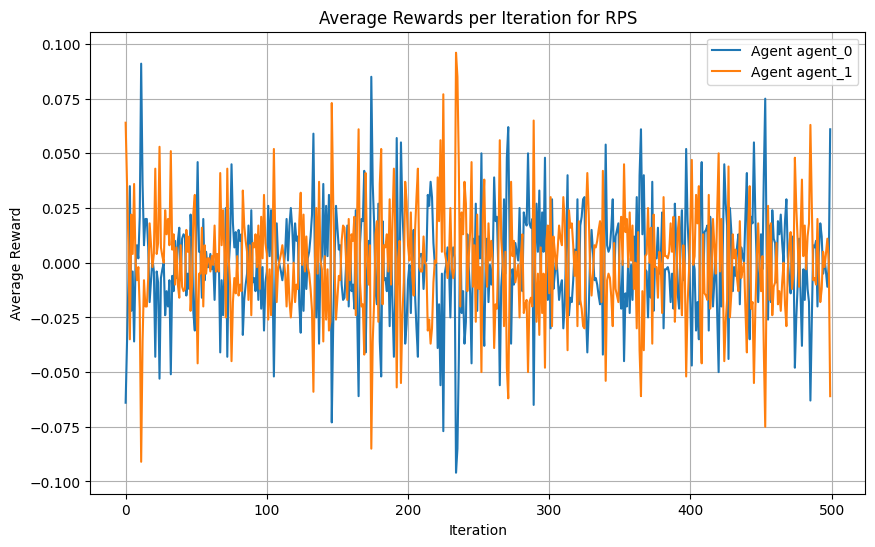

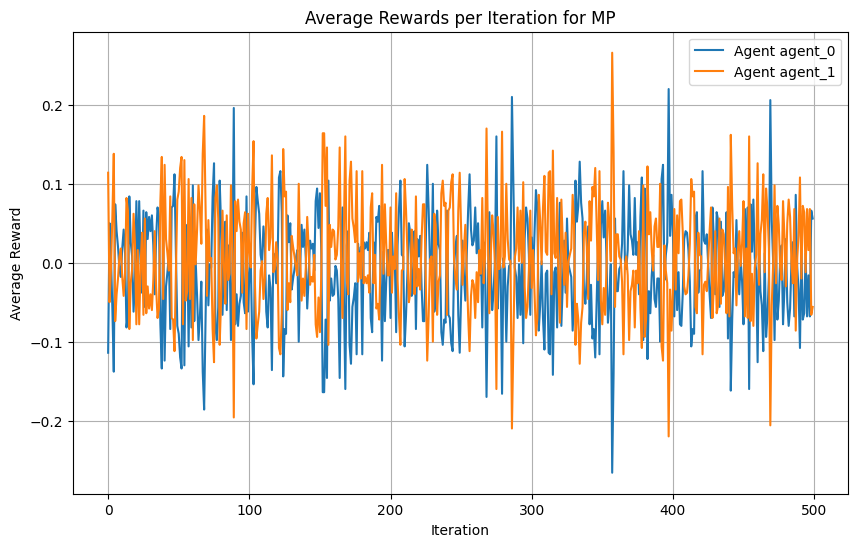

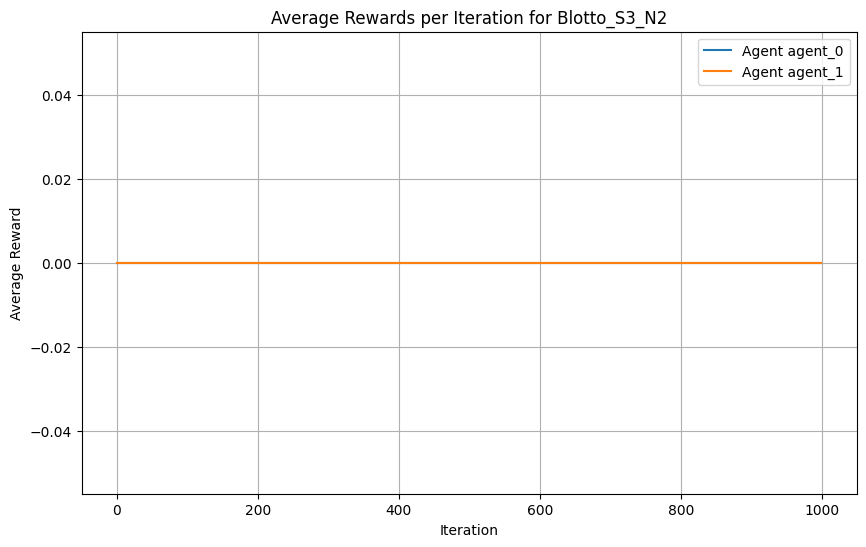

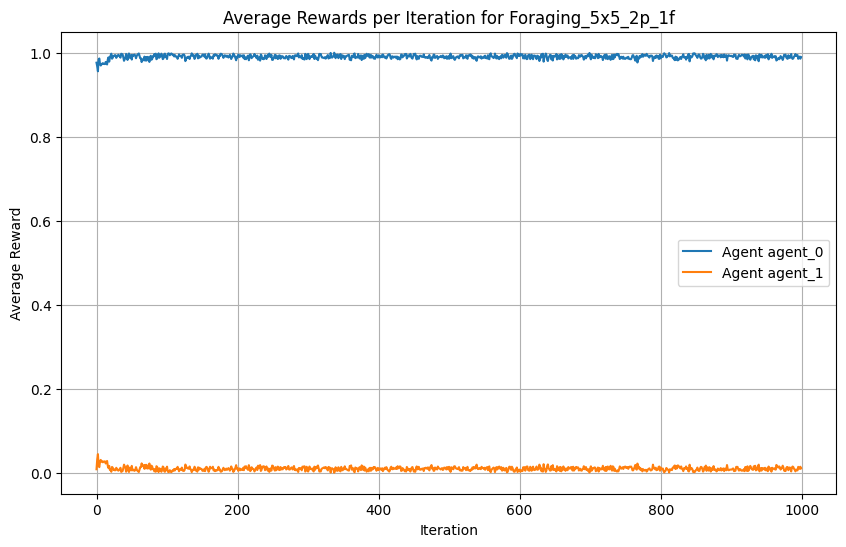

In [12]:
def plot_training_results(game_name, base_path):
    data_path = os.path.join(base_path, game_name, "training_rewards.pkl")
    if not os.path.exists(data_path):
        print(f"No training data found for {game_name} at {data_path}")
        return

    with open(data_path, 'rb') as f:
        training_rewards = pickle.load(f)

    plt.figure(figsize=(10, 6))
    for agent_id, rewards_list in training_rewards.items():
        plt.plot(rewards_list, label=f"Agent {agent_id}")
    
    plt.title(f"Average Rewards per Iteration for {game_name}")
    plt.xlabel("Iteration")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Plot results for the first game trained
if games_to_test:
    first_game_name = games_to_test[0]["name"]
    plot_training_results(first_game_name, TRAINING_DATA_DIR)
    
    second_game_name = games_to_test[1]["name"]
    plot_training_results(second_game_name, TRAINING_DATA_DIR)

    third_game_name = games_to_test[2]["name"]
    plot_training_results(third_game_name, TRAINING_DATA_DIR)

    fourth_game_name = games_to_test[3]["name"]
    plot_training_results(fourth_game_name, TRAINING_DATA_DIR)

## 5. Loading Trained Agents (Example for future use)

This section shows a conceptual way to load the Q-tables back into agents.
This would typically be done in a separate notebook for testing or deployment.

In [11]:
def load_agent_q_table(agent: IQLAgent, game_name: str, agent_id_str: str, base_path: str):
    """Loads a Q-table into an agent from a file."""
    file_path = os.path.join(base_path, game_name, f"agent_{agent_id_str}_q_table.pkl")
    if not os.path.exists(file_path):
        print(f"  No Q-table found for agent {agent_id_str} at {file_path}")
        return False
    
    try:
        with open(file_path, 'rb') as f:
            q_table = pickle.load(f)
        agent.Q = q_table
        agent.learn = False # Typically, when loading a pre-trained model, you turn off learning
        agent.epsilon = 0 # And act greedily
        print(f"  Loaded Q-table for agent {agent_id_str} from {file_path}")
        return True
    except Exception as e:
        print(f"  Error loading Q-table for agent {agent_id_str}: {e}")
        return False

# Example of how you might load agents for a specific game:
# print("--- Example: Loading trained agents for RPS ---")
# rps_game_load_example = RPS() # Create a fresh game instance
# rps_agents_loaded = create_agents(rps_game_load_example) # Create fresh agents

# for agent_id_key, agent_obj_loaded in rps_agents_loaded.items():
#     agent_id_simple_load = str(rps_game_load_example.agent_name_mapping[agent_id_key])
#     load_agent_q_table(agent_obj_loaded, "RPS", agent_id_simple_load, TRAINING_DATA_DIR)

# Now rps_agents_loaded would contain agents with their Q-tables loaded, ready for evaluation.
# You could then run play_episode with learn=False and render=True to see them in action.
# e.g., play_episode(rps_game_load_example, rps_agents_loaded, learn=False, render=True, verbose=True)